https://www.analyticsvidhya.com/blog/2019/06/comprehensive-guide-text-summarization-using-deep-learning-python/

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Data Collection

1. [Dataset is taken from Kaggle](https://www.kaggle.com/snap/amazon-fine-food-reviews)

2. This dataset consists of reviews of fine foods from amazon. The data span a period of more than 10 years, including all ~500,000 reviews up to October 2012. Reviews include product and user information, ratings, and a plain text review. It also includes reviews from all other Amazon categories.

Data includes:

- Reviews from Oct 1999 - Oct 2012
- 568,454 reviews
- 256,059 users
- 74,258 products
- 260 users with > 50 reviews

Columns:

1. Id
2. ProductId - Unique identifier for the product
3. UserId - Unqiue identifier for the user
4. ProfileName - Profile name of user
5. HelpfulnessNumerator - Number of users who found the review helpful
6. HelpfulnessDenominator - Number of users who indicated whether they found the review helpful or not
7. Score - Rating between 1 and 5
8. Time - Timestamp for the review
9. Summary - Brief summary of the review
10. Text - Text of the review


In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

import warnings

import re
from bs4 import BeautifulSoup
from tqdm import tqdm
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping

warnings.filterwarnings("ignore")

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
os.listdir()

['.config', 'drive', 'sample_data']

## Reading Data

In [ ]:
path = r'/content/drive/MyDrive/Colab Notebooks/Kaggle_Project/Text to Summary/Original_data/Reviews.csv'
data = pd.read_csv(path, sep=',')

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [ ]:
data.describe()

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568454.000000,568454.000000,568454.00000,568454.000000,5.684540e+05
mean,284227.500000,1.743817,2.22881,4.183199,1.296257e+09
std,164098.679298,7.636513,8.28974,1.310436,4.804331e+07
min,1.000000,0.000000,0.00000,1.000000,9.393408e+08
25%,142114.250000,0.000000,0.00000,4.000000,1.271290e+09
50%,284227.500000,0.000000,1.00000,5.000000,1.311120e+09
75%,426340.750000,2.000000,2.00000,5.000000,1.332720e+09
max,568454.000000,866.000000,923.00000,5.000000,1.351210e+09


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


## 1. Data Cleaning

### 1.2 Checking duplicates
Reviews might contain duplicate entries.  So, we need to remove the duplicate entries so that we get unbiased data for Analysis.

Check duplicate customers with same Summary and Text.

In [ ]:
data.shape

(568454, 10)

In [ ]:
data.duplicated(subset=["UserId", "Summary", "Text", "Time"]).value_counts()

False    395131
True     173323
dtype: int64

As we can see that we have 160678 duplicate customers with same Summary and Text.

Let's remove those customers. 

In [ ]:
# drop duplicated data
data.drop_duplicates(subset={"UserId", "Summary", "Text", "Time"}, keep='first', inplace=True)
data.shape

(395131, 10)

## 2. Preprocessing Review Text

We will perform the below preprocessing tasks:
- Convert everything to lowercase
- Remove HTML tags
- Remove URL from sentence
- Contraction mapping
- Eliminate punctuations and special characters
- Remove stopwords
- Remove short words

In [ ]:
stopwords = nltk.corpus.stopwords.words('english')
print(stopwords)
len(stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

179

In [ ]:
!pip install contractions

In [ ]:
import contractions

In [ ]:
def decontracted(sentance):
    expanded_words = []    
    for word in sentance.split():
      # using contractions.fix to expand the shotened words
      expanded_words.append(contractions.fix(word))   

    expanded_text = ' '.join(expanded_words)
    return expanded_text

In [ ]:
def sentance_clean(sentance):
    # change sentence to lower case
    sentance = sentance.lower()
    # removing URL from sentence
    sentance = re.sub(r"http\S+", "", sentance)
    # removing HTML tags
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    # removing contraction of words from sentence   # call decontracted funtion for it
    sentance = decontracted(sentance)
    # removing digits
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    # removing special character
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    
    return sentance

In [ ]:
# Performing the preprocessing steps on all messages
def preprocess(document, min_token_length):
    preprocessed_reviews = []
    # tqdm is for printing the status bar
    for sentance in tqdm(document):
        # call sentance_clean function to clean text
        sentance = sentance_clean(sentance)
        # tokenize into words
        words = word_tokenize(sentance)
        # remove stop words
        tokens = [word for word in words if word not in stopwords]

        long_words = []
        for i in tokens:
            if len(i)>=min_token_length:                  #removing short word
                long_words.append(i)   

        # join words to make sentence
        sentance = " ".join(long_words).strip()

        preprocessed_reviews.append(sentance)
        
    return preprocessed_reviews

In [ ]:
data = data[['Summary', 'Text']]

In [ ]:
data_copy = data.copy()
data_copy.shape, data.shape

((395131, 2), (395131, 2))

In [ ]:
# frac = 1.0
# data = data.sample(frac=frac)
# data.shape

(395131, 2)

### 2.1 Preprocessing on `Text`

In [ ]:
%%time
preprocessed_text = preprocess(data['Text'], min_token_length=3)

100%|██████████| 395131/395131 [08:01<00:00, 821.29it/s]

CPU times: user 7min 53s, sys: 7.47 s, total: 8min
Wall time: 8min 1s


### 2.1 Preprocessing on `Text`

In [ ]:
%%time
count = len(data['Summary'])
preprocessed_summary = preprocess(data['Summary'], min_token_length=1)

100%|██████████| 395131/395131 [02:52<00:00, 2295.93it/s]

CPU times: user 2min 47s, sys: 6.59 s, total: 2min 53s
Wall time: 2min 52s


In [ ]:
data['cleaned_text'] = preprocessed_text
data['cleaned_summary'] = preprocessed_summary

Add the START and END special tokens at the beginning and end of the summary:


In [ ]:
data['cleaned_summary'] = data['cleaned_summary'].apply(lambda x : '_START_ '+ x + ' _END_')

**Print Summary and Text after text processing.**

In [ ]:
for i in range(5):
    print("Review:",data['cleaned_text'].iloc[i])
    print("Summary:",data['cleaned_summary'].iloc[i])
    print("\n")

Review: rice lentil dinner son absolute favorite know gobbles every time enjoys earth best foods found couple eat anything much apple personal taste issue brand particular combination varieties tend runny one great consistency right jar
Summary: _START_ baby favorite dinner _END_


Review: part review provided cairn terrier owner transcribing notes terrier says never crazy dry dog food especially compared great mushy stuff comes smelled tasted good pounced immediately scarfed right begged tastes like meat guess divascribe surprised quickly dog took food never particularly enthusiastic dry food bag says real beef ingredient looked ingredient list beef listed first long long list ingredients sound appetizing poultry byproduct meal unfortunately case dog food nice beefy scent got dog stick head bowl concern older dog might bit rich plan mix regular dry dog food problems far though one happy dog
Summary: _START_ yum _END_


Review: taste smell fresh star reviews absolutely right beans lack

Dump dataframe

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Kaggle_Project/Text to Summary/Dump_data/'
path_and_name = path+'text_processed_data.pkl'

In [ ]:
def dump_unpack(filename, df=None,  dump=True):
    if dump:
        df.to_pickle(filename)
    else:
      with open(filename, 'rb') as f:
          new_data = pickle.load(f)
          return new_data

In [ ]:
# dump_unpack(path_and_name, data, dump=True)

In [ ]:
# unpack
data = dump_unpack(path_and_name, dump=False)

## Understanding the distribution of the sequences

In [ ]:
text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

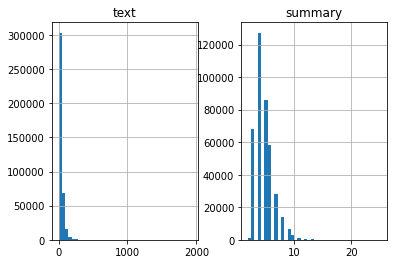

In [ ]:
length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})
length_df.hist(bins = 40)
plt.show()

In [ ]:
max_len_text = 80 
max_len_summary = 10

## Creating a train and test set

In [ ]:
X = data['cleaned_text']
Y = data['cleaned_summary']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=123)

In [ ]:
print("X_train size:", len(X_train))
print("X_test size:", len(X_test))

X_train size: 316104
X_test size: 79027


## Tokenizer

In [ ]:
def tokenizer(train, test):
    # prepare a tokenizer for summary on training data
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(list(train))

    # convert summary sequences into integer sequences
    train = tokenizer.texts_to_sequences(train)
    test = tokenizer.texts_to_sequences(test)

    # padding zero upto maximum length
    train = pad_sequences(train, maxlen=max_len_text, padding='post') 
    test = pad_sequences(test, maxlen=max_len_text, padding='post')

    voc_size = len(tokenizer.word_index) + 1
    print("Vocabulary Size:", voc_size)

    return train, test, voc_size, tokenizer

### a) Text Tokenizer

In [ ]:
%%time
X_train, X_test, x_voc_size, x_tokenizer = tokenizer(X_train, X_test)

Vocabulary Size: 107398
CPU times: user 28.4 s, sys: 392 ms, total: 28.8 s
Wall time: 28.5 s


### b) Summary Tokenizer

In [ ]:
%%time
y_train, y_test, y_voc_size, y_tokenizer = tokenizer(y_train, y_test)

Vocabulary Size: 29037
CPU times: user 10.1 s, sys: 101 ms, total: 10.2 s
Wall time: 10.2 s


In [ ]:
y_tokenizer.index_word

{1: 'start',
 2: 'end',
 3: 'great',
 4: 'good',
 5: 'best',
 6: 'love',
 7: 'coffee',
 8: 'tea',
 9: 'product',
 10: 'delicious',
 11: 'taste',
 12: 'excellent',
 13: 'like',
 14: 'flavor',
 15: 'tasty',
 16: 'price',
 17: 'yummy',
 18: 'ever',
 19: 'food',
 20: 'dog',
 21: 'favorite',
 22: 'stuff',
 23: 'better',
 24: 'free',
 25: 'chocolate',
 26: 'healthy',
 27: 'snack',
 28: 'awesome',
 29: 'tastes',
 30: 'loves',
 31: 'nice',
 32: 'yum',
 33: 'perfect',
 34: 'sweet',
 35: 'wonderful',
 36: 'quality',
 37: 'really',
 38: 'dogs',
 39: 'one',
 40: 'bad',
 41: 'tasting',
 42: 'buy',
 43: 'i',
 44: 'hot',
 45: 'sugar',
 46: 'cat',
 47: 'treat',
 48: 'amazing',
 49: 'mix',
 50: 'little',
 51: 'gluten',
 52: 'easy',
 53: 'candy',
 54: 'organic',
 55: 'much',
 56: 'cup',
 57: 'value',
 58: 'sauce',
 59: 'ok',
 60: 'cats',
 61: 'treats',
 62: 'cereal',
 63: 'way',
 64: 'k',
 65: 'fantastic',
 66: 'pretty',
 67: 'drink',
 68: 'amazon',
 69: 'works',
 70: 'green',
 71: 'oil',
 72: 'get',
 7